In [2]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import IPython.display as ipd
from scipy.signal import medfilt
import scipy.io as sio
import math
import pyaudio
import wave
import ipywidgets as widgets
import soundfile as sf
import io
import audioop
import time

/var/folders/g8/gzsznbld27x17kyd_7smlhxw0000gn/T/ipykernel_35072/2194701035.py:13: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop


### Implement TSM with dynamically changing time stretch factor in an offline setting 
In hw10 we implemented the following function
y = tsm_hybrid(x, alpha=1.0, sr=22050)
Where x is the input audio, y is the output audio, alpha is the global TSM factor, and sr is the sample rate
* You will implement the following function
y = tsm_hybrid_variable(x, sr, t_alpha, alpha)
x, sr, and y are same as above
alpha is a 1-d array specifying the desired TSM factors at different points in time
t_alpha is a 1-d array of the same size as alpha that specifies the time (in sec, in the timeline of the original unmodified audio recording) when the TSM factor should be changed/set; the first value of this array should always be zero (in order to set the initial TSM factor)
* You can think of t_alpha and alpha as a way of simulating a  person controlling the slider where they make a discrete number of changes over the length of the recording
E.g. if t_alpha = [0,2.5, 7.5] and alpha = [1.0, 2.0, 0.5], then the first 2.5 sec of the original audio should be played with no TSM, the next 7.5 - 2.5 = 5 sec of the original audio should be played with time stretch factor 2x, and the rest of the recording should be played with time stretch factor 0.5.

Use a simple example like this to verify that your code is working properly – you should be able to double check that the total duration is what is expected, and also listen to confirm that it is doing the time stretch properly


#### Helper functions

In [4]:
def invert_stft(S, hop_length, window):
    '''
    Reconstruct a signal from a modified STFT matrix.
    
    Inputs
    S: modified STFT matrix
    hop_length: the synthesis hop size in samples
    window: an array specifying the window used for FFT analysis
    
    Returns a time-domain signal y whose STFT is closest to S in squared error distance.
    '''
    
    L = len(window)
    
    # construct full stft matrix
    fft_size = (S.shape[0] - 1) * 2
    Sfull = np.zeros((fft_size, S.shape[1]), dtype=np.complex64)
    Sfull[0:S.shape[0],:] = S
    Sfull[S.shape[0]:,:] = np.conj(np.flipud(S[1:fft_size//2,:]))
    
    # compute inverse FFTs
    frames = np.zeros_like(Sfull)
    for i in range(frames.shape[1]):
        frames[:,i] = np.fft.ifft(Sfull[:,i])
    frames = np.real(frames) # remove imaginary components due to numerical roundoff
    
    # synthesis frames
    num = window.reshape((-1,1))
    den = calc_sum_squared_window(window, hop_length)
    #den = np.square(window) + np.square(np.roll(window, hop_length))
    frames = frames * window.reshape((-1,1)) / den.reshape((-1,1))
    #frames = frames * window.reshape((-1,1))
    
    # reconstruction
    y = np.zeros(hop_length*(frames.shape[1]-1) + L)
    for i in range(frames.shape[1]):
        offset = i * hop_length
        y[offset:offset+L] += frames[:,i]
    
    return y

In [5]:
def calc_sum_squared_window(window, hop_length):
    '''
    Calculates the denominator term for computing synthesis frames.
    
    Inputs
    window: array specifying the window used in FFT analysis
    hop_length: the synthesis hop size in samples
    
    Returns an array specifying the normalization factor.
    '''
    assert (len(window) % hop_length == 0), "Hop length does not divide the window evenly."
    
    numShifts = len(window) // hop_length
    den = np.zeros_like(window)
    for i in range(numShifts):
        den += np.roll(np.square(window), i*hop_length)
        
    return den

In [6]:
def harmonic_percussive_separation(x, sr=22050, fft_size = 2048, hop_length=512, lh=6, lp=6):
    
    window = np.hanning(fft_size)
    X = lb.core.stft(x, n_fft=fft_size, hop_length=512, window=window, center=False)
    Y = np.abs(X)
    Yh = medfilt(Y, (1, 2*lh+1))
    Yp = medfilt(Y, (2*lp+1, 1))
    Mh = (Yh > Yp)
    Mp = np.logical_not(Mh)
    Xh = X * Mh
    Xp = X * Mp
    xh = invert_stft(Xh, hop_length, window)
    xp = invert_stft(Xp, hop_length, window)
    
    return xh, xp, Xh, Xp

In [7]:
def mix_recordings(x1, x2):
    min_length = min(len(x1), len(x2))
    y = .5 * (x1[0:min_length] + x2[0:min_length])
    return y

### Including dynamic variable

#### tsm_ola_variable, applying OLA when we have a dynamic variable $\alpha$

In [8]:
choir, c_sr = lb.load("choir.wav")
beatbox, bb_sr = lb.load("beatbox.wav")

In [9]:
def tsm_ola_variable(x, sr, t_alpha, alpha, L=220):
    '''
    Time stretches the input signal using overlap-add with variable stretch factors.
    
    Inputs:
    x: input signal
    sr: sample rate
    t_alpha: array of time points (seconds) when stretch factors change
    alpha: array of stretch factors corresponding to t_alpha
    L: frame length (must be even)
    
    Returns time-stretched signal y
    '''
    assert L % 2 == 0, "Frame length must be even."
    Hs = L // 2
    
    # Convert time points to samples
    t_alpha_samples = [int(t * sr) for t in t_alpha]
    t_alpha_samples.append(len(x))  # Add end of signal as final boundary
    
    # Initialize
    current_alpha_idx = 0
    curr_offset = 0
    analysis_frames = []
        
    # Analysis phase
    while curr_offset <= len(x) - L:
        current_alpha = alpha[current_alpha_idx]
        Ha = int(np.round(Hs / current_alpha))

        # Check if next window would cross boundary
        if curr_offset + Ha > t_alpha_samples[current_alpha_idx + 1]:
            current_alpha_idx += 1
        
        # Extract and store frame
        frame = x[curr_offset:curr_offset + L]
        analysis_frames.append(frame)        
        # Advance position
        curr_offset += Ha
    
    num_frames = len(analysis_frames)
    if num_frames == 0:
        return np.zeros(0)
    
    analysis_frames = np.array(analysis_frames).T
    
    # Synthesis phase
    synthesis_frames = analysis_frames * hann_window(L).reshape((-1, 1))
    y = np.zeros(Hs * (num_frames-1) + L)
    
    for i in range(num_frames):
        offset = i * Hs
        y[offset:offset + L] += synthesis_frames[:, i]
    
    return y

In [10]:
def hann_window(L):
    w = .5 * (1 - np.cos(2*np.pi * np.arange(L)/ L))
    return w

In [11]:
t_alpha = [0]
alpha = [0.75]
beatbox_ola = tsm_ola_variable(beatbox, bb_sr, t_alpha, alpha)
choir_ola = tsm_ola_variable(choir, c_sr, t_alpha, alpha)

In [12]:
ipd.Audio(beatbox_ola, rate=bb_sr)

In [13]:
ipd.Audio(choir_ola, rate=c_sr)

#### tsm_phase_vocoder_variable, applying phase vocoder when we have a dynamic variable $\alpha$

In [14]:
def tsm_phasevocoder_variable(x, sr, t_alpha, alpha, L=2048):
    """
    Phase‐vocoder time‐scale modification with piecewise constant speed factors.
    
    Parameters
    ----------
    x : np.ndarray
        Input audio signal (1D array of samples).
    sr : int
        Sampling rate in Hz.
    t_alpha : list of float
    alpha : list of float
        Speed factors corresponding to each segment defined by `t_alpha`.
    L : int, optional
        FFT size and window length (defaults to 2048 samples).
    
    Returns
    -------
    y : np.ndarray
        Time‐scaled output signal.
    """
    Hs = L // 4
    window = np.hanning(L)  # Hann window of length L

    t_alpha_samples = [int(t * sr) for t in t_alpha] + [len(x)]
    prev_fft = None # stores the FFT of the previous frame (None for first frame)
    prev_phase = np.zeros(L//2 + 1) # half of the size of FFT
    currOffset = 0 # current read pointer in the input x
    seg_idx = 0 # which segment (alpha[seg_idx]) we’re in
    analysisFrames = []

    # precompute nominal angular frequencies for each FFT bin
    omega_nom = np.arange(L//2 + 1) * 2 * np.pi * sr / L

    # main processing loop
    while currOffset + L <= len(x): # stop when not enough frame for entire window
        if currOffset >= t_alpha_samples[seg_idx + 1]:
            seg_idx += 1 # if we’ve crossed the next time boundary, increment seg_idx.
        a  = alpha[seg_idx] #the speed factor for this frame.
        Ha = int(round(Hs / a)) # Ha length in terms of Hs --> output_length approx input_length * (Ha / Hs)

        # extract, window, and FFT the current frame
        frame = x[currOffset : currOffset + L] * window
        S     = np.fft.rfft(frame)

    # estimate IF
        if prev_fft is None: # nothing for first frame
            w_if = np.zeros_like(omega_nom)
        else:
            
            dphi = np.angle(S) - np.angle(prev_fft) # phase difference between current & previous FFT
            dphi = dphi - omega_nom * (Ha / sr)
            
            dphi = (dphi + np.pi) % (2 * np.pi) - np.pi # wrap to [-π, π] to undo any 2π jumps
            w_if = omega_nom + dphi * (sr / Ha) # IF = nom + correction
 
        prev_phase = prev_phase + w_if * (Hs / sr) # accumulates phase after every time boundary

        # build the modified spectrum & inverse FFT back to time domain
        X_mod = np.abs(S) * np.exp(1j * prev_phase)
        frame_mod = np.fft.irfft(X_mod)
        analysisFrames.append(frame_mod)

        # advance pos
        currOffset  += Ha
        prev_fft   = S

    numFrames = len(analysisFrames)
    analysisFrames = np.array(analysisFrames).T
    den = calc_sum_squared_window(window, Hs)
    synthesisFrames = analysisFrames * window.reshape((-1,1)) / den.reshape((-1,1))
    y = np.zeros((Hs*numFrames)+L)

    for i in range(numFrames):
        offset = i * Hs
        y[offset: offset + L] += synthesisFrames[:, i]

    return y


In [15]:
t_alpha = [0, 2.5, 7.5]
alpha = [1, 2, 0.5]

In [16]:
choirVocoderStart = time.perf_counter()

choir_vocoder = tsm_phasevocoder_variable(choir, c_sr, t_alpha, alpha)

choirVocoderEnd = time.perf_counter()

choirVocoderTime = choirVocoderEnd - choirVocoderStart

print(f"Runtime: {choirVocoderTime}")



Runtime: 0.3325109750003321


In [17]:
BBVocoderStart = time.perf_counter()


beatbox_vocoder = tsm_phasevocoder_variable(beatbox, bb_sr, t_alpha, alpha)


BBVocoderEnd = time.perf_counter()

BBVocoderTime = BBVocoderEnd - BBVocoderStart

print(f"Runtime: {BBVocoderTime}")

Runtime: 0.23523254199972143


In [18]:
ipd.Audio(choir_vocoder, rate=c_sr)

In [19]:
ipd.Audio(beatbox_vocoder, rate=bb_sr)

### optimizing PV function

In [20]:
def precompute_stft_frames(x, L=2048, Ha_base=2048//512):
    if Ha_base is None:
        Ha_base = L // 8    # instead of L//4, choose L//8 or even L//16
    window = np.hanning(L).astype(np.float32)
    frames = []
    for start in range(0, len(x) - L + 1, Ha_base):
        frame = x[start:start + L] * window
        S = np.fft.rfft(frame)
        frames.append(S)
    return np.array(frames), window, Ha_base


In [21]:
def tsm_phasevocoder_precomputed(x, sr, STFT, window, t_alpha, alpha, L=2048, Hs=512, Ha_base=2048//512):
    """
    Phase vocoder time-scale modification using a precomputed STFT bank.
    Includes linear interpolation between FFT frames to improve smoothness.
    """

    # Convert segment time boundaries from seconds to sample indices
    # t_alpha defines when alpha (speed factor) changes; we add len(x) as the final boundary
    t_alpha_samps = [int(t * sr) for t in t_alpha] + [len(x)]

    # Get number of FFT frames and frequency bins from the precomputed STFT
    n_frames, n_bins = STFT.shape

    # Precompute the nominal angular frequencies (omega) for each FFT bin
    omega_nom = np.arange(n_bins) * 2 * np.pi * sr / L

    # Variables for tracking previous frame and output phase
    prev_fft = None
    prev_phase = np.zeros(n_bins, dtype=np.float32)  # initialized to 0 phase
    y_frames = []  # list to hold processed output frames
    curr_t = 0.0   # "virtual" read position in input (can be fractional)
    seg_idx = 0    # index of current alpha segment

    # Main time-scaling loop
    while True:
        # If we're past the end of the current time segment, move to the next
        if seg_idx < len(alpha) - 1 and curr_t >= t_alpha_samps[seg_idx + 1]:
            seg_idx += 1

        # Get the current speed factor
        a = alpha[seg_idx]

        # Compute how far ahead to jump in the input STFT (in samples)
        Ha = Hs / a                    # analysis hop size (smaller for slow-down, larger for speed-up)
        next_t = curr_t + Ha          # virtual read pointer advances by Ha

        # Find the fractional index into the precomputed STFT array
        fpos = next_t / Ha_base       # fractional frame index in STFT
        i0 = int(np.floor(fpos))      # lower index
        w = fpos - i0                 # interpolation weight (between 0 and 1)
        i1 = i0 + 1                   # upper index

        # If we’ve reached the end of the STFT bank, we’re done
        if i1 >= n_frames:
            break

        # Retrieve the two FFT frames for interpolation
        S0 = STFT[i0]
        S1 = STFT[i1]

        # INTERPOLATE MAGNITUDE
        # Linearly blend magnitudes of neighboring STFT frames
        mag0 = np.abs(S0)
        mag1 = np.abs(S1)
        mag = (1 - w) * mag0 + w * mag1

        # INTERPOLATE PHASE
        # Extract phases from both STFT frames
        ph0 = np.angle(S0)
        ph1 = np.angle(S1)

        # Compute shortest angular difference between phases
        dph = (ph1 - ph0 + np.pi) % (2 * np.pi) - np.pi

        # Linearly interpolate unwrapped phase difference
        ph = ph0 + w * dph

        # Construct the interpolated FFT with new magnitude and phase
        S = mag * np.exp(1j * ph)

        # INSTANTANEOUS FREQUENCY ESTIMATION
        if prev_fft is None:
            # First frame: no IF estimate, use zero
            w_if = np.zeros_like(omega_nom)
        else:
            # Estimate phase advance from previous to current frame
            dphi = np.angle(S) - np.angle(prev_fft)
            dphi -= omega_nom * (Ha / sr)       # remove expected phase advance
            dphi = (dphi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]
            w_if = omega_nom + dphi * (sr / Ha) # true instantaneous frequency

        # PHASE ACCUMULATION
        # Update running phase accumulator to generate coherent output
        prev_phase = prev_phase + w_if * (Hs / sr)

        # INVERSE FFT BACK TO TIME DOMAIN
        # Use updated phase and interpolated magnitude
        X_mod = mag * np.exp(1j * prev_phase)
        frame_mod = np.fft.irfft(X_mod)          # convert to time domain
        y_frames.append(frame_mod)               # store frame for overlap-add

        # Update previous FFT and advance read pointer
        prev_fft = S
        curr_t = next_t

    # OVERLAP-ADD SYNTHESIS
    # Transpose from list of frames to matrix: each column = one frame
    analysis_frames = np.array(y_frames).T

    # Calculate normalization factor from window function
    den = calc_sum_squared_window(window, Hs)

    # Apply window and normalize each frame
    synthesis = analysis_frames * window.reshape(-1, 1) / den.reshape(-1, 1)

    # Initialize output buffer large enough to hold all frames
    y_len = int(Hs * len(y_frames)) + L
    y = np.zeros(y_len, dtype=np.float32)

    # Overlap-add all frames into final output
    for i, frame in enumerate(synthesis.T):
        start = int(i * Hs)
        y[start:start + L] += frame

    return y  # return the synthesized, time-scaled signal

In [22]:
# def precompute_stft_frames(x, L=2048, Ha_base=2048//512):
# def tsm_phasevocoder_precomputed(x, sr, STFT, window, t_alpha, alpha, L=2048, Hs=512, Ha_base=2048//512):
t_alpha = [0, 2.5, 7.5]
alpha = [1.25, 1.0, 0.75]

choirPrecomputed, choirWindow, choirHa_base = precompute_stft_frames(choir)

beatboxPrecomputed, bbWindow, bbHa_base = precompute_stft_frames(beatbox)

In [23]:
# import time

# start_time = time.perf_counter()

# # Code to be timed
# for i in range(100000):
#     _ = i * i

# end_time = time.perf_counter()

# execution_time = end_time - start_time
# print(f"Execution time: {execution_time:.4f} seconds")

In [24]:
pStartChoir = time.perf_counter()

yChoirPre = tsm_phasevocoder_precomputed(choir, c_sr, choirPrecomputed, choirWindow, t_alpha, alpha) ###

pEndChoir = time.perf_counter()

pChoirRuntime = pEndChoir - pStartChoir

print(f"Runtime: {pChoirRuntime}")



Runtime: 0.23557485000492306


In [25]:
pStartBB = time.perf_counter()

yBBPre = tsm_phasevocoder_precomputed(beatbox, bb_sr, beatboxPrecomputed, bbWindow, t_alpha, alpha) ###

pEndBB = time.perf_counter()

pBBRuntime = pEndBB - pStartBB

print(f"Runtime: {pBBRuntime}")

Runtime: 0.20000314399658237


In [26]:
ipd.Audio(yChoirPre, rate=c_sr)

In [27]:
ipd.Audio(yBBPre, rate=bb_sr)

#### tsm_hybrid_variable, applying hybrid method when we have a dynamic variable $\alpha$

In [28]:
def tsm_hybrid_variable(x, sr, alpha, t_alpha):
    """
    Inputs:
    x - input signal
    sr - sampling rate
    alpha - a list of stretch factos
    t_alpha - a list of times (in seconds) where the stretch factor, alpha, applies e.g. alpha = [1, 0.5, 2] and t_alpha = [0, 2.5, 6]
    then from 0 to 2.5 secs, alpha = 1, then from 2.5 to 6 secs, alpha = 0.5 and so on. 
    """
    xh, xp, _, _ = harmonic_percussive_separation(x)
    xh_stretched = tsm_phasevocoder_variable(xh, sr, t_alpha, alpha)
    xp_stretched = tsm_ola_variable(xp, sr, t_alpha, alpha)
    y = mix_recordings(xh_stretched, xp_stretched)
    return y

In [29]:
t_alpha = [0, 2.5, 6]
alpha = [1, 1.25, 0.75]

In [30]:
beatbox_y = tsm_hybrid_variable(beatbox, bb_sr, alpha, t_alpha)

In [31]:
choir_y = tsm_hybrid_variable(choir, c_sr, alpha, t_alpha)

In [32]:
ipd.Audio(beatbox_y, rate=bb_sr)

In [33]:
ipd.Audio(choir_y, rate=c_sr)

### Faster ver. of Hybrid method

In [34]:
# Preprocessing step (done once before user interaction)

# def precompute_stft_frames(x, L=2048, Ha_base=2048//512):
# def tsm_phasevocoder_precomputed(x, sr, STFT, window, t_alpha, alpha, L=2048, Hs=512, Ha_base=2048//512):
Choirxh, Choirxp, _, _ = harmonic_percussive_separation(choir, sr=c_sr)

beatboxxh, beatboxxp, _, _ = harmonic_percussive_separation(beatbox, sr=bb_sr)



In [35]:
def tsm_hybrid_variable_optimized(xh, xp, sr, alpha, t_alpha, precomputed, window):
    """
    Inputs:
    x - input signal
    sr - sampling rate
    alpha - a list of stretch factos
    t_alpha - a list of times (in seconds) where the stretch factor, alpha, applies e.g. alpha = [1, 0.5, 2] and t_alpha = [0, 2.5, 6]
    then from 0 to 2.5 secs, alpha = 1, then from 2.5 to 6 secs, alpha = 0.5 and so on. 
    """
    
    xh_stretched = tsm_phasevocoder_precomputed(xh, sr, precomputed, window, t_alpha, alpha)
    xp_stretched = tsm_ola_variable(xp, sr, t_alpha, alpha)
    y = mix_recordings(xh_stretched, xp_stretched)
    return y

In [36]:
t_alpha = [0, 2.5, 6]
alpha = [1, 1.25, 0.75]

In [37]:
beatbox_yopt = tsm_hybrid_variable_optimized(beatboxxh, beatboxxp, bb_sr, alpha, t_alpha, beatboxPrecomputed, bbWindow)

In [38]:
ipd.Audio(beatbox_yopt, rate=bb_sr)

In [39]:
choir_yopt = tsm_hybrid_variable_optimized(Choirxh, Choirxp, c_sr, alpha, t_alpha, choirPrecomputed, choirWindow)

In [40]:
ipd.Audio(choir_yopt, rate=bb_sr)

### Runtime analysis

In [24]:
fred_10, sr = lb.load("samples/fred_10sec.wav")
fred_20, sr = lb.load("samples/fred_20sec.wav")
fred_30, sr = lb.load("samples/fred_30sec.wav")
fred_40, sr = lb.load("samples/fred_40sec.wav")
fred_50, sr = lb.load("samples/fred_50sec.wav")
fred_60, sr = lb.load("samples/fred_60sec.wav")
fred_70, sr = lb.load("samples/fred_70sec.wav")

In [38]:
var_alpha = 1.25
runtime_mean = np.array([0.06365428639,
0.1281297968,
0.1750564522,
0.2333193296,
0.2784497486,
0.3401895834,
0.391278849]) # alpha = 0.5

runtime_mean1 = np.array([0.09057614679,
0.1717561886,
0.2495600772,
0.3343530636,
0.4222515614,
0.5155571432,
0.5637251138]) # alpha = 0.75

runtime_mean2 = np.array([0.140052388,
0.2808714622,
0.4318614892,
0.568129026,
0.6884244576,
0.835103952,
0.960564754
]) # alpha 1.25

In [39]:
expected_dur = np.array([len(fred_10) * var_alpha * 1/sr, len(fred_20) * var_alpha * 1/sr, len(fred_30) * var_alpha * 1/sr, len(fred_40) * var_alpha * 1/sr, len(fred_50) * var_alpha * 1/sr, len(fred_60) * var_alpha * 1/sr, len(fred_70) * var_alpha * 1/sr])

In [34]:
ratio_runtime = runtime_mean/expected_dur

In [37]:
ratio_runtime1 = runtime_mean1/expected_dur

In [40]:
ratio_runtime2 = runtime_mean2/expected_dur

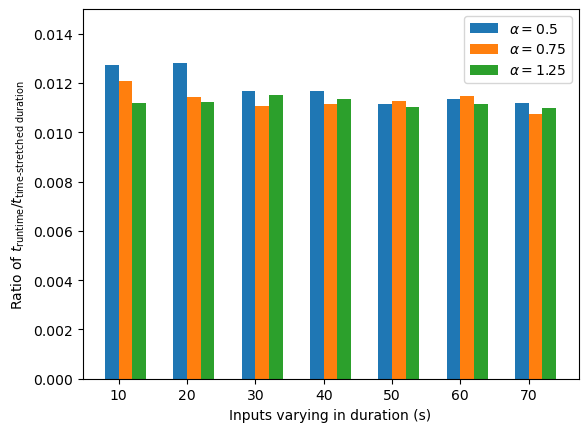

In [63]:
# Define the width of the bars
width = 2
# Set the positions of the bars on the x-axis
x = np.arange(0, 70, 10) + 10

# Create the figure and axes object
fig, ax = plt.subplots()

# Plot the bars for men and women, shifting them to the side
rects1 = ax.bar(x - width/2, ratio_runtime, width, label=r'$\alpha = 0.5$')
rects2 = ax.bar(x + width/2, ratio_runtime1, width, label=r'$\alpha = 0.75$')
rects3 = ax.bar(x + 3*width/2, ratio_runtime2, width, label=r'$\alpha = 1.25$')

ax.set_ylim([0, 0.015])
ax.set_xlabel("Inputs varying in duration (s)")
ax.set_ylabel(r"Ratio of $t_{\text{runtime}} / t_{\text{time-stretched duration}}$")
ax.legend()

<BarContainer object of 7 artists>

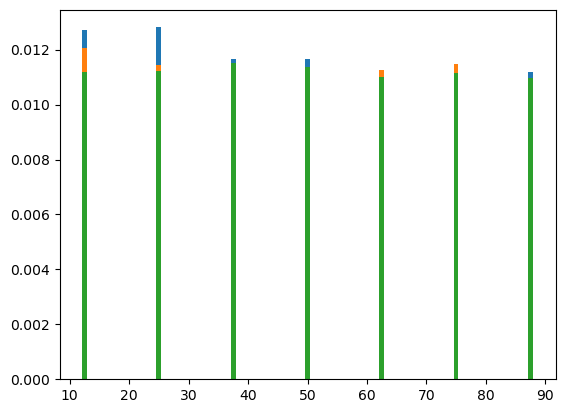

In [42]:
plt.bar(expected_dur, ratio_runtime)
plt.bar(expected_dur, ratio_runtime1)
plt.bar(expected_dur, ratio_runtime2)

In [15]:
runtime_10sec = np.loadtxt("runtime_10sec.csv")
runtime_30sec = np.loadtxt("runtime_30sec.csv")
runtime_60sec = np.loadtxt("runtime_60sec.csv")

In [44]:
np.mean(runtime_10sec), np.mean(runtime_30sec), np.mean(runtime_60sec)

(0.0232207399103139, 0.023215175424413904, 0.023218435663224783)

In [25]:
runtime_means = np.array([np.mean(runtime_10sec), np.mean(runtime_30sec), np.mean(runtime_60sec)])

In [28]:
runtime_std = np.array([np.std(runtime_10sec), np.std(runtime_30sec), np.std(runtime_60sec)])

Text(0, 0.5, 'Runtime average by chunk (s)')

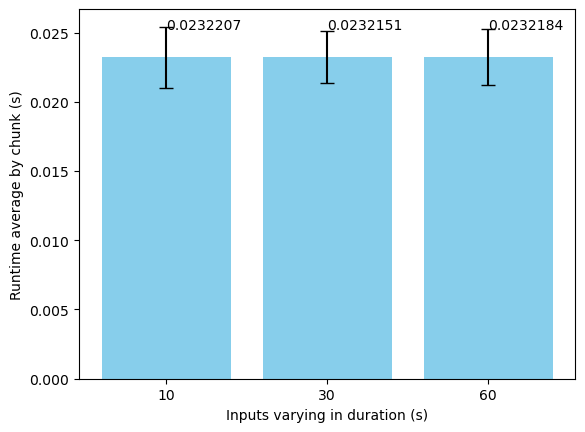

In [ ]:
plt.bar(['10', '30', '60'], runtime_means, yerr=runtime_std, capsize=5, color='skyblue')
for index, value in enumerate(runtime_means):
    plt.text(index, value + 0.002, str(value)[0:9])
plt.xlabel("Inputs varying in duration (s)")
plt.ylabel("Runtime average by chunk (s)" \
"")

Text(0.5, 1.0, 'Precaculation stage runtime analysis')

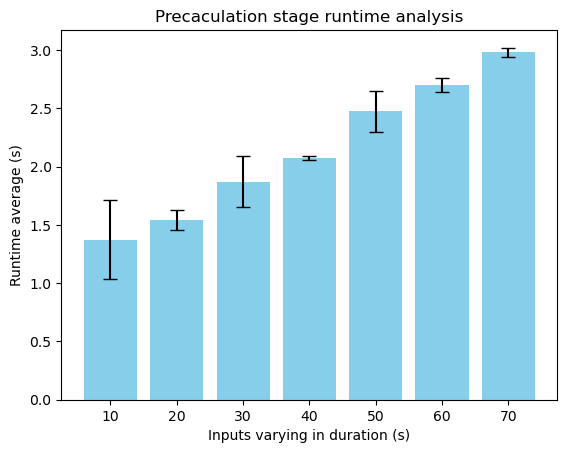

In [14]:
precalc_runtime = np.array([1.374210236, 1.544457605, 1.869803979, 2.074823687, 2.476543957, 2.702885526, 2.981759789])
precalc_std = np.array([0.3356516529, 0.08439008904, 0.2195462209, 0.0197965334, 0.1761435871, 0.06042076009, 0.03888054887])
plt.bar(['10', '20', '30', '40', '50', '60','70'], precalc_runtime, yerr=precalc_std, capsize=5, color='skyblue')
# for index, value in enumerate(precalc_runtime):
#     plt.text(index, value, str(value)[0:5])
plt.xlabel("Inputs varying in duration (s)")
plt.ylabel("Runtime average (s)")
plt.title("Precaculation stage runtime analysis")